In [1]:
import os
os.environ['HF_HOME'] = '/om2/user/ericjm/.cache/huggingface'
# os.environ['HF_HOME'] = '/Users/eric/.cache/huggingface'

import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm.auto import tqdm

from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from huggingface_hub import hf_hub_download, notebook_login

# umap and tsne
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

In [2]:
model = "google/gemma-2-2b"
repo_id = "google/gemma-scope-2b-pt-res"
sae_name = "layer_12/width_16k/average_l0_41"

path_to_params = hf_hub_download(
    repo_id=repo_id,
    filename=sae_name + "/params.npz",
    # revision="0127b340ca980c3ee81df0275cea35f350f83488"
    revision="0127b340ca980c3ee81df0275cea35f350f83488"
    # Use df97476f53d8d01f64113094d0ccbe3425f257b7 instead for google/gemma-scope-2b-pt-mlp
)

params = np.load(path_to_params)
W_dec = params['W_dec']

In [ ]:
# perform tSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate=100)
W_dec_tsne = tsne.fit_transform(W_dec)
# np.save
np.save('W_dec_tsne_gemma-2-2b_res_layer_12_width_16k_average_l0_41.npy', W_dec_tsne)

In [3]:
W_dec_tsne = np.load('W_dec_tsne_gemma-2-2b_res_layer_12_width_16k_average_l0_41.npy')

In [4]:
# load up occurrence and co-occurrence data
occurrence_npz = np.load(f"../experiments/all-occurrences0/histograms/pile_{model.replace('/', '_')}_res_{sae_name.replace('/', '_')}_occurrences.npz")
occurrence_hist, occurrence_n_tokens = occurrence_npz['histogram'], occurrence_npz['n_tokens']

In [5]:
# number of dead features
(occurrence_hist == 0).sum()

6

In [6]:
cooccurrence_npz = np.load(f"../experiments/all-occurrences0/cooc-histograms/pile_{model.replace('/', '_')}_res_{sae_name.replace('/', '_')}_docs50k_keq256_cooccurrences.npz")
cooccurrence_hist, cooccurrence_n_chunks = cooccurrence_npz['histogram'], cooccurrence_npz['n_chunks']

In [7]:
freqs = occurrence_hist / occurrence_n_tokens
# freq_hist, freq_bins = np.histogram(freqs, bins=np.logspace(-7, 0, 100))
# plt.plot(freq_bins[:-1], freq_hist, color='C0', label='occurrence')
# plt.xscale('log')
# plt.yscale('log')

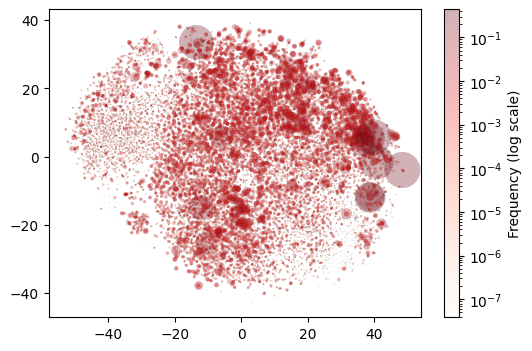

In [8]:
# plot the tsne again but weighted by frequency
frequencies = freqs
frequencies[frequencies == 0] = 1e-7

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

def normalize(frequencies):
    min_f = np.min(frequencies)
    max_f = np.max(frequencies)
    return (np.log(frequencies) - np.log(min_f)) / (np.log(max_f) - np.log(min_f))

plt.figure(figsize=(6, 4))

# Create a colormap (using the default grey colormap, not reversed)
cmap = plt.cm.Reds

# Create a normalization object
norm = colors.LogNorm(vmin=np.min(frequencies), vmax=np.max(frequencies))

# Create the scatter plot
scatter = plt.scatter(W_dec_tsne[:, 0], W_dec_tsne[:, 1], 
                s=frequencies*15e2, 
                c=frequencies,
                alpha=0.3,
                # next, add a border around the points
                edgecolor='black', linewidth=0.1,
                cmap=cmap, 
                norm=norm)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Frequency (log scale)')

In [13]:
# plt.imshow(cooccurrence_hist[:100, :100], cmap='viridis')

In [9]:
# load cooccurrence clusters from disk
clustering_results = np.load(f"../experiments/all-occurrences0/clusters/pile_{model.replace('/', '_')}_res_{sae_name.replace('/', '_')}_docs50k_keq256_cooccurrences_clusters.npz")
clustering_results = {int(k): v for k, v in clustering_results.items()}
n_clusterss = list(clustering_results.keys())

In [10]:
clustering_results_ang = np.load(f"../experiments/all-occurrences0/ang_clusters/{repo_id.replace('/', '_')}_{sae_name.replace('/', '_')}_ang_sims_clusters.npz")
clustering_results_ang = {int(k): v for k, v in clustering_results_ang.items()}
n_clusterss_ang = list(clustering_results_ang.keys())

In [11]:
# import normalized_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score

In [12]:
normalized_mis = []
for n_clusters in n_clusterss:
    normalized_mis.append(normalized_mutual_info_score(clustering_results[n_clusters], clustering_results_ang[n_clusters]))

adjusted_mis = []
for n_clusters in n_clusterss:
    adjusted_mis.append(adjusted_mutual_info_score(clustering_results[n_clusters], clustering_results_ang[n_clusters]))


Text(0, 0.5, 'Mutual Information between clustering methods')

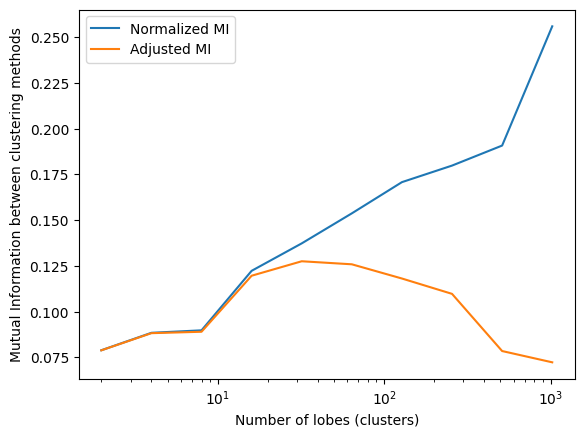

In [13]:
plt.plot(n_clusterss, normalized_mis, label='Normalized MI')
plt.plot(n_clusterss, adjusted_mis, label='Adjusted MI')
plt.xscale('log')
plt.legend()
plt.xlabel("Number of lobes (clusters)")
plt.ylabel("Mutual Information between clustering methods")

In [ ]:
# random baseline analysis
# for all clustering results, compute normalized mutual information and adjusted mutual information with multiple random permutations of the clustering assignments


In [29]:
# now we should do a grid search over the following: 
# PCA projection dimenion: [8, 32, 128, 512]
# all cluster sizes we have access to (n_clusterss)

pca_dims = [8, 32, 128, 512, 1024, W_dec.shape[1]]

pcas = dict()
for pca_d in tqdm(pca_dims):
    if pca_d == W_dec.shape[1]:
        W_dec_pca = W_dec
    else:
        pca = PCA(n_components=pca_d)
        W_dec_pca = pca.fit_transform(W_dec)
    pcas[pca_d] = W_dec_pca

  0%|          | 0/6 [00:00<?, ?it/s]

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
# perform fits
split = 0.8

fit_results = dict()
for pca_d in tqdm(pca_dims):
    for n_clusters in n_clusterss:
        # perform logistic regression
        labels = clustering_results[n_clusters]
        X = pcas[pca_d]
        train_labels, test_labels = labels[:int(len(labels)*split)], labels[int(len(labels)*split):]
        train_X, test_X = X[:int(len(labels)*split)], X[int(len(labels)*split):]
        clf = LogisticRegression(max_iter=1000).fit(train_X, train_labels)
        score = clf.score(test_X, test_labels)
        fit_results[(pca_d, n_clusters)] = (clf, score)

  0%|          | 0/6 [00:00<?, ?it/s]

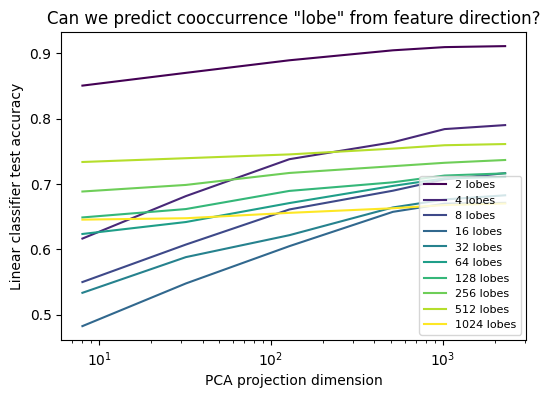

In [33]:
# for each n_clusters, plot the scores vs. pca_d
plt.figure(figsize=(6, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(n_clusterss)))
for n_clusters in n_clusterss:
    scores = [fit_results[(pca_d, n_clusters)][1] for pca_d in pca_dims]
    plt.plot(pca_dims, scores, label=f"{n_clusters} lobes", color=colors[n_clusterss.index(n_clusters)])
plt.xlabel("PCA projection dimension")
plt.ylabel("Linear classifier test accuracy")
plt.title('Can we predict cooccurrence "lobe" from feature direction?')
plt.xscale('log')
plt.legend(loc='lower right', prop={'size': 8})

In [ ]:
# plot some clusters

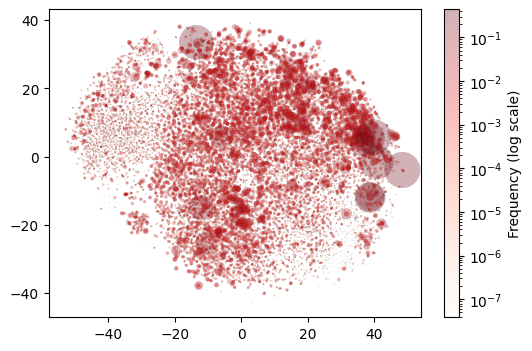

In [34]:
# plot the tsne again but weighted by frequency
frequencies = freqs
frequencies[frequencies == 0] = 1e-7

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

def normalize(frequencies):
    min_f = np.min(frequencies)
    max_f = np.max(frequencies)
    return (np.log(frequencies) - np.log(min_f)) / (np.log(max_f) - np.log(min_f))

plt.figure(figsize=(6, 4))

# Create a colormap (using the default grey colormap, not reversed)
cmap = plt.cm.Reds

# Create a normalization object
norm = colors.LogNorm(vmin=np.min(frequencies), vmax=np.max(frequencies))

# Create the scatter plot
scatter = plt.scatter(W_dec_tsne[:, 0], W_dec_tsne[:, 1], 
                s=frequencies*15e2, 
                c=frequencies,
                alpha=0.3,
                # next, add a border around the points
                edgecolor='black', linewidth=0.1,
                cmap=cmap, 
                norm=norm)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Frequency (log scale)')

(-57.96066398620606, 54.101273727416995, -47.08945198059082, 43.15426368713379)

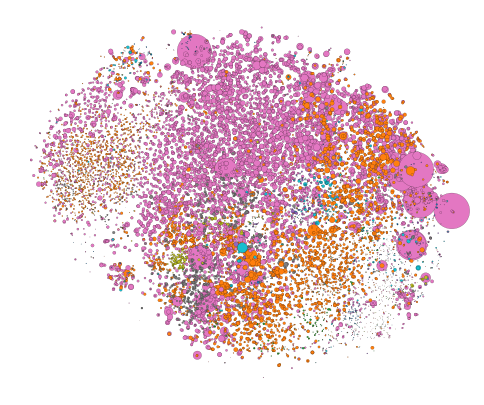

In [51]:
n_clusters = 32
# clusteri = 1

# plot the tsne again but weighted by frequency
frequencies = freqs
frequencies[frequencies == 0] = 1e-7

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

# def normalize(frequencies):
#     min_f = np.min(frequencies)
#     max_f = np.max(frequencies)
#     return (np.log(frequencies) - np.log(min_f)) / (np.log(max_f) - np.log(min_f))

plt.figure(figsize=(6, 5))

# Create a colormap (using the default grey colormap, not reversed)
# cmap = plt.cm.Reds

# Create a normalization object
# norm = colors.LogNorm(vmin=np.min(frequencies), vmax=np.max(frequencies))


for clusteri in range(n_clusters):
    idxs = clustering_results[n_clusters] == clusteri
    # Create the scatter plot
    scatter = plt.scatter(W_dec_tsne[idxs, 0], W_dec_tsne[idxs, 1], 
                    s=frequencies[idxs]*15e2, 
                    # c=frequencies[idxs],
                    alpha=1.0,
                    # next, add a border around the points
                    edgecolor='black', linewidth=0.1,
                    color=f'C{clusteri % n_clusters}',
                    # cmap=cmap,
                    # norm=norm)
    )
plt.axis('off')
# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label('Frequency (log scale)')

(-57.96066398620606, 54.101273727416995, -47.08945198059082, 43.15426368713379)

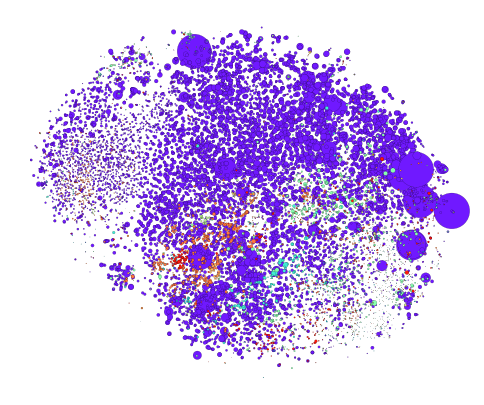

In [52]:
n_clusters = 512
# clusteri = 1

# plot the tsne again but weighted by frequency
frequencies = freqs
frequencies[frequencies == 0] = 1e-7

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

# def normalize(frequencies):
#     min_f = np.min(frequencies)
#     max_f = np.max(frequencies)
#     return (np.log(frequencies) - np.log(min_f)) / (np.log(max_f) - np.log(min_f))

plt.figure(figsize=(6, 5))

# Create a colormap (using the default grey colormap, not reversed)
# cmap = plt.cm.Reds

# Create a normalization object
# norm = colors.LogNorm(vmin=np.min(frequencies), vmax=np.max(frequencies))

colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))

for clusteri in range(n_clusters):
    idxs = clustering_results[n_clusters] == clusteri
    # Create the scatter plot
    scatter = plt.scatter(W_dec_tsne[idxs, 0], W_dec_tsne[idxs, 1], 
                    s=frequencies[idxs]*15e2, 
                    # c=frequencies[idxs],
                    alpha=1.0,
                    # next, add a border around the points
                    edgecolor='black', linewidth=0.1,
                    # color=f'C{clusteri % n_clusters}',
                    color = colors[clusteri],
                    # cmap=cmap,
                    # norm=norm)
    )
plt.axis('off')
# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label('Frequency (log scale)')

In [27]:
fit_results

{(8, 2): 0.8428440646933171,
 (8, 4): 0.6203844980164784,
 (8, 8): 0.5495880378394873,
 (8, 16): 0.4800122062862374,
 (8, 32): 0.534330180042722,
 (32, 2): 0.8709185230393652,
 (32, 4): 0.6841623436069576,
 (32, 8): 0.6084833689350015,
 (32, 16): 0.5477570949038755,
 (32, 32): 0.5877326823314006,
 (128, 2): 0.8904485810192249,
 (128, 4): 0.7421422032346658,
 (128, 8): 0.6576136710405859,
 (128, 16): 0.6078730546231309,
 (128, 32): 0.6255721696673787,
 (512, 2): 0.9029600244125725,
 (512, 4): 0.7668599328654256,
 (512, 8): 0.6832468721391517,
 (512, 16): 0.6576136710405859,
 (512, 32): 0.6603600854440037}

In [19]:
d_pca = 1000
n_clusters = n_clusterss[-1]
clusters = clustering_results[n_clusters]

# perform PCA projection of W_dec
pca = PCA(n_components=d_pca)
W_dec_pca = pca.fit_transform(W_dec)

KeyboardInterrupt: 

In [20]:
# fit a linear classifier to the PCA projection to get the clusters
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(W_dec, clusters)

LogisticRegression(max_iter=1000)

In [21]:
(clf.predict(W_dec) == clusters).mean()

0.71630859375

In [10]:
# compute the jaccard similarities between from the co-occurrence matrix
# jacc_ij = cooccurrence_ij / (cooccurrence_ii + cooccurrence_jj - cooccurrence_ij)
diag = np.diag(cooccurrence_hist)
unions = diag[:, np.newaxis] + diag - cooccurrence_hist
jaccard = cooccurrence_hist / unions
# save division by zero
jaccard[np.isnan(jaccard)] = 0

/tmp/ipykernel_741125/1572549690.py:5: RuntimeWarning: invalid value encountered in divide
  jaccard = cooccurrence_hist / unions


In [11]:
# spectral clustering on the jaccard similarity matrix
from sklearn.cluster import SpectralClustering

In [63]:
sc = SpectralClustering(n_clusters=2, affinity='precomputed')
clusters = sc.fit_predict(jaccard)

/om2/user/ericjm/miniconda3/envs/features/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


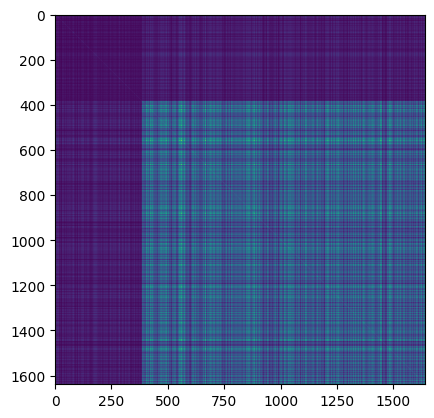

In [66]:
perm = np.argsort(clusters)
cooccurrence_hist_sorted = cooccurrence_hist[perm][:, perm]
# plot the sorted co-occurrence matrix, subsampled
plt.imshow(cooccurrence_hist_sorted[::10, ::10], cmap='viridis')

In [13]:
n_clusterss = [2, 3, 4, 5, 6, 7, 8, 9, 10]
clustering_results = dict()
for n_clusters in tqdm(n_clusterss):
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    clusters = sc.fit_predict(jaccard)
    clustering_results[n_clusters] = clusters

  0%|          | 0/9 [00:00<?, ?it/s]

/om2/user/ericjm/miniconda3/envs/features/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/om2/user/ericjm/miniconda3/envs/features/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/om2/user/ericjm/miniconda3/envs/features/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/om2/user/ericjm/miniconda3/envs/features/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/om2/user/ericjm/miniconda3/envs/features/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: 

In [12]:
# load clustering_results from disk
clustering_results = np.load("clusters0.npz")

In [13]:
clustering_results = {int(k): v for k, v in clustering_results.items()}

In [14]:
n_clusterss = list(clustering_results.keys())

12528
3856


Text(0.5, 1.0, 'n_clusters = 2')

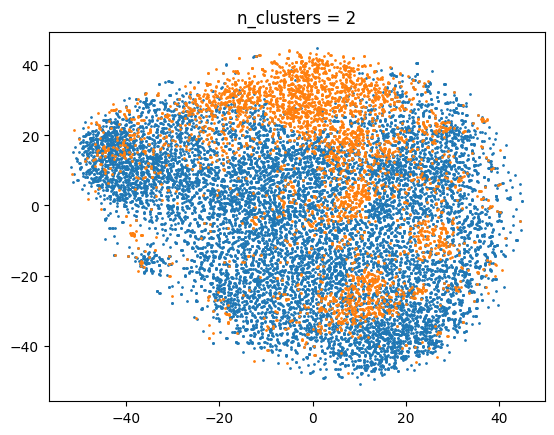

In [21]:
n_clusters = n_clusterss[0]
clusters = clustering_results[n_clusters]
for clusteri in range(n_clusters):
    indices = np.where(clusters == clusteri)[0]
    print(len(indices))
    plt.scatter(W_dec_tsne[indices, 0], W_dec_tsne[indices, 1], s=1)
plt.title(f"n_clusters = {n_clusters}")

(-56.65505313873291,
 49.915860176086426,
 -55.86387271881104,
 49.589164924621585)

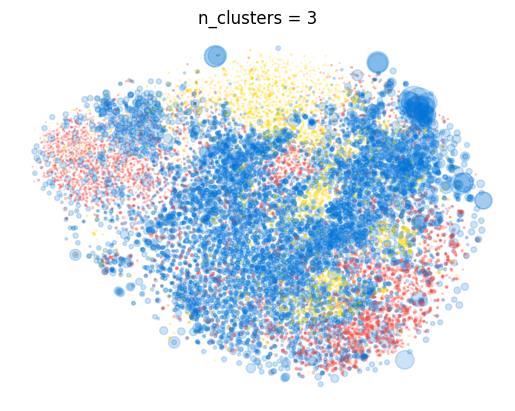

In [50]:
colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
          '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']

n_clusters = n_clusterss[1]
clusters = clustering_results[n_clusters]

plot_chunks = 10
# break the SAE feature indices into chunks
chunk_indices = np.array_split(np.arange(W_dec_tsne.shape[0]), plot_chunks)
for chunk_is in chunk_indices:
    chunk_colors = [colors[clusteri] for clusteri in clusters[chunk_is]]
    plt.scatter(
        W_dec_tsne[chunk_is, 0], 
        W_dec_tsne[chunk_is, 1], 
        s=frequencies[chunk_is]*5e2, 
        alpha=0.2,
        color=chunk_colors)

# for clusteri in range(n_clusters):
#     indices = np.where(clusters == clusteri)[0]
#     print(len(indices))
#     plt.scatter(W_dec_tsne[indices, 0], W_dec_tsne[indices, 1], 
#         # s=1,
#         s=frequencies[indices]*5e2,
#         c olor=colors[clusteri], 
#         alpha=0.2)
plt.title(f"n_clusters = {n_clusters}")
plt.axis('off')

In [40]:
chunk_indices[9].shape

(1489,)

In [53]:
# save the clusters to disk
np.savez("clusters0.npz", **{str(nc): cl for nc, cl in clustering_results.items()})

In [52]:
# place all of these into the same 3x3 plot
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, n_clusters in enumerate(n_clusterss):
    clusters = clustering_results[n_clusters]
    plot_chunks = 10
    # break the SAE feature indices into chunks
    chunk_indices = np.array_split(np.arange(W_dec_tsne.shape[0]), plot_chunks)
    for chunk_is in chunk_indices:
        chunk_colors = [colors[clusteri] for clusteri in clusters[chunk_is]]
        axs[i // 3, i % 3].scatter(
            W_dec_tsne[chunk_is, 0], 
            W_dec_tsne[chunk_is, 1], 
            s=frequencies[chunk_is]*5e2, 
            alpha=0.2,
            color=chunk_colors)
    # for clusteri in range(n_clusters):
    #     indices = np.where(clusters == clusteri)[0]
    #     axs[i // 3, i % 3].scatter(W_dec_tsne[indices, 0], W_dec_tsne[indices, 1], 
    #         # s=1,
    #         s=frequencies[indices]*5e2,
    #         color=colors[clusteri], 
    #         alpha=0.2)
    axs[i // 3, i % 3].set_title(f"n_clusters = {n_clusters}")
    axs[i // 3, i % 3].axis('off')
# save
# plt.savefig("spectral-clustering0.png", dpi=400)

In [53]:
# do a pca on the SAE features
pca = PCA(n_components=2)
W_dec_pca = pca.fit_transform(W_dec)

Text(0.5, 0.98, 'PCA of SAE decoder features (gemma-2-2b, layer_12/width_16k/canonical)')

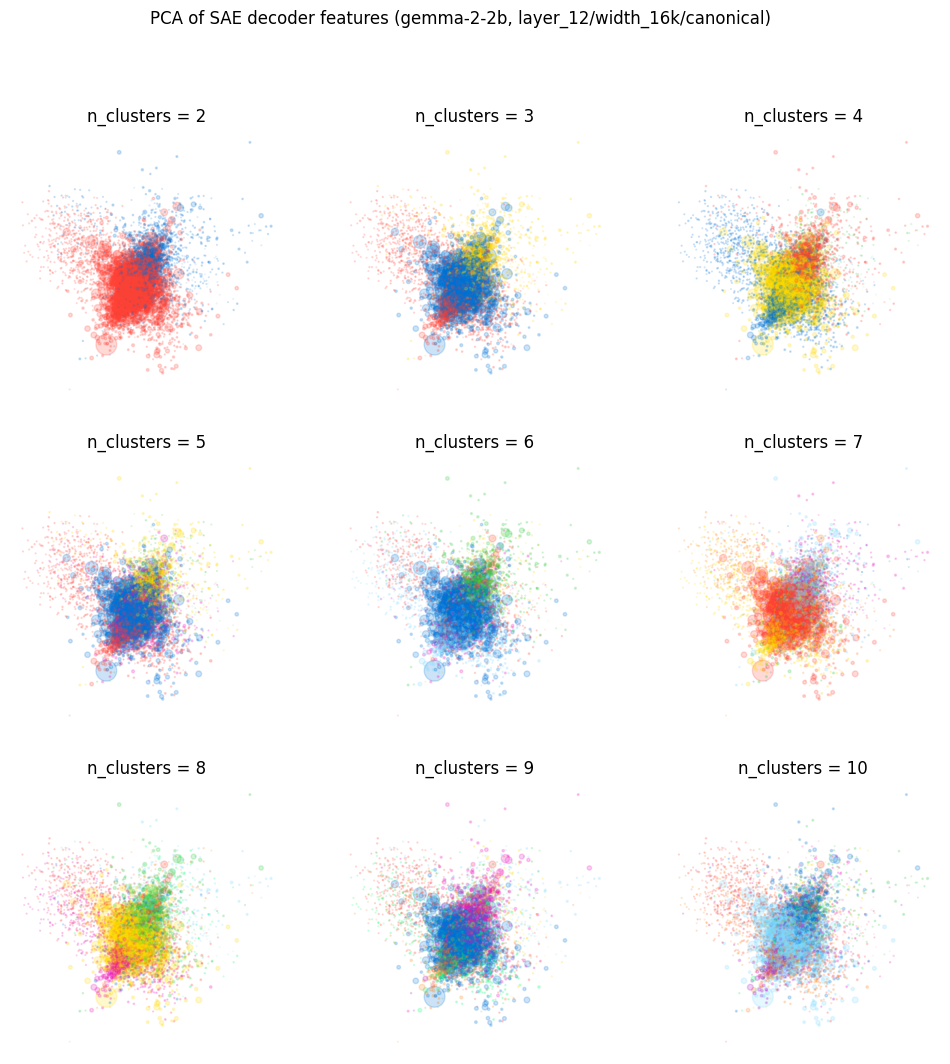

In [55]:
# place all of these into the same 3x3 plot
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, n_clusters in enumerate(n_clusterss):
    clusters = clustering_results[n_clusters]
    plot_chunks = 10
    # break the SAE feature indices into chunks
    chunk_indices = np.array_split(np.arange(W_dec_tsne.shape[0]), plot_chunks)
    for chunk_is in chunk_indices:
        chunk_colors = [colors[clusteri] for clusteri in clusters[chunk_is]]
        axs[i // 3, i % 3].scatter(
            W_dec_pca[chunk_is, 0], 
            W_dec_pca[chunk_is, 1], 
            s=frequencies[chunk_is]*5e2, 
            alpha=0.2,
            color=chunk_colors)
    # for clusteri in range(n_clusters):
    #     indices = np.where(clusters == clusteri)[0]
    #     axs[i // 3, i % 3].scatter(W_dec_tsne[indices, 0], W_dec_tsne[indices, 1], 
    #         # s=1,
    #         s=frequencies[indices]*5e2,
    #         color=colors[clusteri], 
    #         alpha=0.2)
    axs[i // 3, i % 3].set_title(f"n_clusters = {n_clusters}")
    axs[i // 3, i % 3].axis('off')
plt.suptitle("PCA of SAE decoder features (gemma-2-2b, layer_12/width_16k/canonical)")
# plt.savefig("spectral-clustering0.png", dpi=400)

In [15]:
cos_sims = W_dec @ W_dec.T
# clip between -1 and 1
cos_sims = np.clip(cos_sims, -1, 1)
ang_sims = 1 - np.arccos(cos_sims) / np.pi

In [16]:
# perform spectral clustering on the cosine similarity matrix
from sklearn.cluster import SpectralClustering
from tqdm.auto import tqdm

n_clusterss = [2, 4, 8]
ang_clustering_results = dict()
for n_clusters in tqdm(n_clusterss):
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    clusters = sc.fit_predict(ang_sims)
    ang_clustering_results[n_clusters] = clusters


  0%|          | 0/3 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Clusters from angular similarity matrix, rather than co-occurrence')

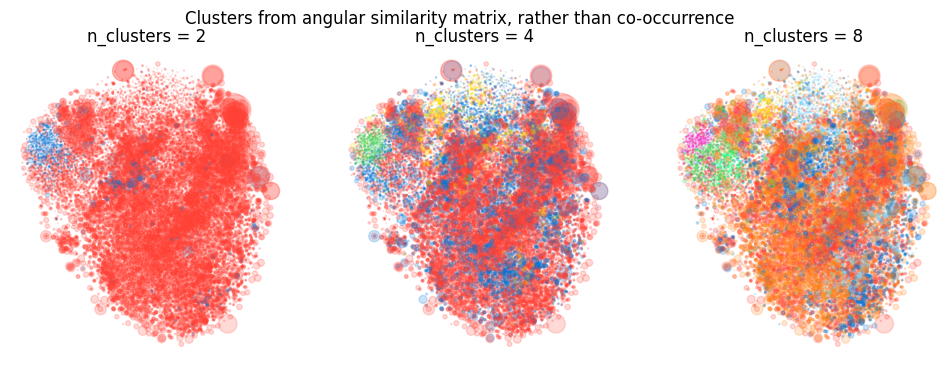

In [75]:
# place all of these into the same 3x3 plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, n_clusters in enumerate(n_clusterss):
    clusters = ang_clustering_results[n_clusters]
    plot_chunks = 10
    # break the SAE feature indices into chunks
    chunk_indices = np.array_split(np.arange(W_dec_tsne.shape[0]), plot_chunks)
    for chunk_is in chunk_indices:
        chunk_colors = [colors[clusteri] for clusteri in clusters[chunk_is]]
        axs[i].scatter(
            W_dec_tsne[chunk_is, 0], 
            W_dec_tsne[chunk_is, 1], 
            s=frequencies[chunk_is]*5e2, 
            alpha=0.2,
            color=chunk_colors)
    # for clusteri in range(n_clusters):
    #     indices = np.where(clusters == clusteri)[0]
    #     axs[i // 3, i % 3].scatter(W_dec_tsne[indices, 0], W_dec_tsne[indices, 1], 
    #         # s=1,
    #         s=frequencies[indices]*5e2,
    #         color=colors[clusteri], 
    #         alpha=0.2)
    axs[i].set_title(f"n_clusters = {n_clusters}")
    axs[i].axis('off')
plt.suptitle("Clusters from angular similarity matrix, rather than co-occurrence")
# save
# plt.savefig("spectral-clustering0.png", dpi=400)

In [17]:
W_dec_random = np.random.randn(*W_dec.shape) # gaussian random noise
# normalize
W_dec_random /= np.linalg.norm(W_dec_random, axis=1, keepdims=True)

In [18]:
# perform tSNe on these random features
tsne = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate=100)
W_dec_random_tsne = tsne.fit_transform(W_dec_random)

In [19]:
# angular similarity spectral clustering of W_dec_random
cos_sims_random = W_dec_random @ W_dec_random.T
# clip between -1 and 1
cos_sims_random = np.clip(cos_sims_random, -1, 1)
ang_sims_random = 1 - np.arccos(cos_sims_random) / np.pi


In [20]:
# perform spectral clustering on the cosine similarity matrix
from sklearn.cluster import SpectralClustering
from tqdm.auto import tqdm

n_clusterss = [2, 4, 8]
ang_clustering_results_random = dict()
for n_clusters in tqdm(n_clusterss):
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
    clusters = sc.fit_predict(ang_sims_random)
    ang_clustering_results_random[n_clusters] = clusters

  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
          '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']

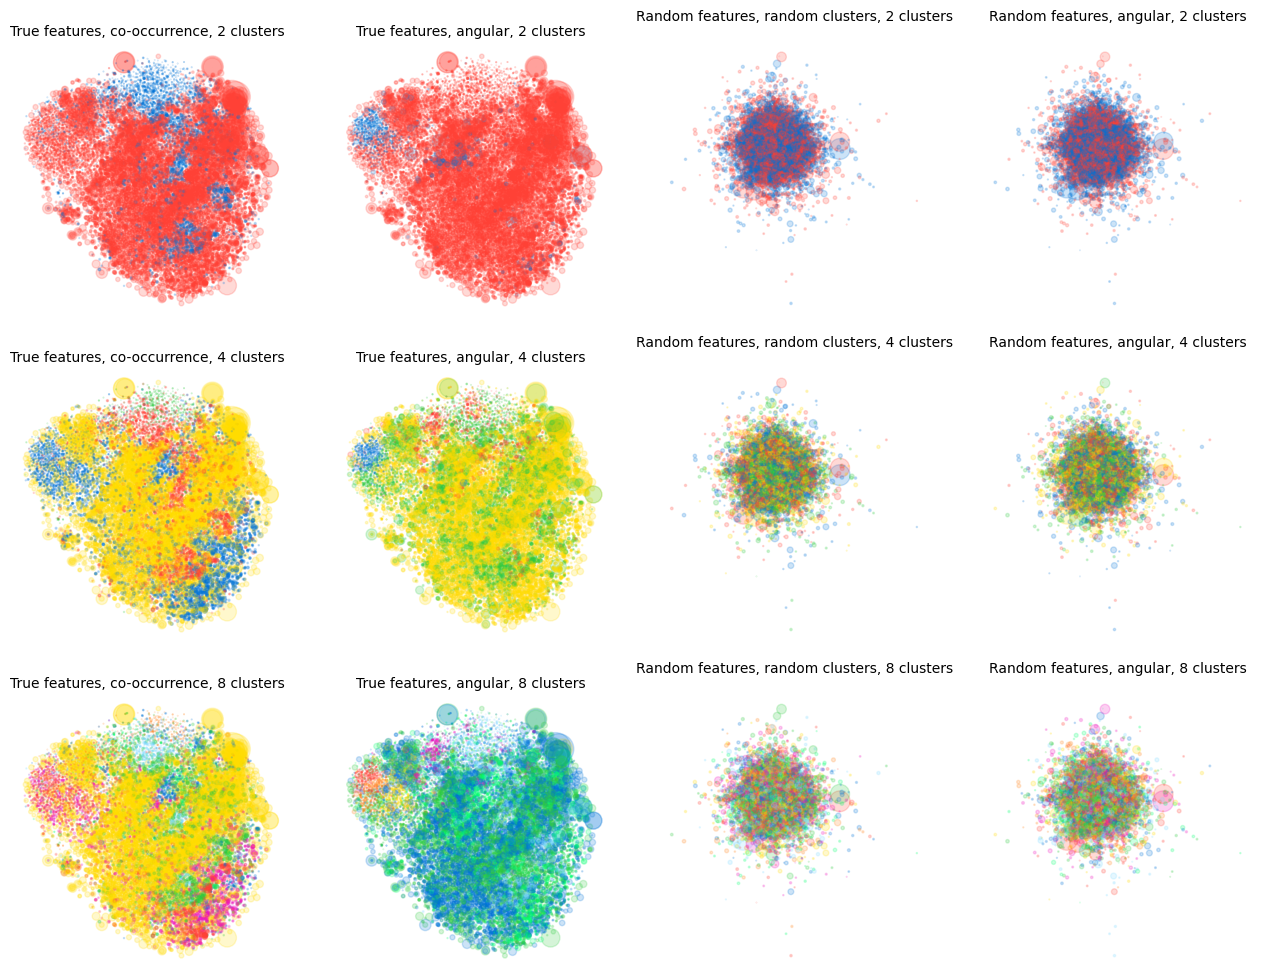

In [31]:
# plot these with random cluster assignments
plt.figure(figsize=(16, 12))

n_clusterss = [2, 4, 8]
for i, n_clusters in enumerate(n_clusterss):
    
    # plot the co-occurrence clusters of the actual data
    plt.subplot(3, 4, 4*i+1)
    clusters = clustering_results[n_clusters]
    plot_chunks = 10
    # break the SAE feature indices into chunks
    chunk_indices = np.array_split(np.arange(W_dec_tsne.shape[0]), plot_chunks)
    for chunk_is in chunk_indices:
        chunk_colors = [colors[clusteri] for clusteri in clusters[chunk_is]]
        plt.scatter(
            W_dec_tsne[chunk_is, 0], 
            W_dec_tsne[chunk_is, 1], 
            s=frequencies[chunk_is]*5e2, 
            alpha=0.2,
            color=chunk_colors)
    plt.title(f"True features, co-occurrence, {n_clusters} clusters", fontsize=10)
    plt.axis('off')

    # plot the true features with angular similarity clusters
    plt.subplot(3, 4, 4*i+2)
    clusters = ang_clustering_results[n_clusters]
    plot_chunks = 10
    # break the SAE feature indices into chunks
    chunk_indices = np.array_split(np.arange(W_dec_tsne.shape[0]), plot_chunks)
    for chunk_is in chunk_indices:
        chunk_colors = [colors[clusteri] for clusteri in clusters[chunk_is]]
        plt.scatter(
            W_dec_tsne[chunk_is, 0], 
            W_dec_tsne[chunk_is, 1], 
            s=frequencies[chunk_is]*5e2, 
            alpha=0.2,
            color=chunk_colors)
    plt.title(f"True features, angular, {n_clusters} clusters", fontsize=10)
    plt.axis('off')

    # plot the random features with random clusters
    plt.subplot(3, 4, 4*i+3)
    clusters = np.random.randint(0, n_clusters, W_dec_random.shape[0])
    plt.scatter(W_dec_random_tsne[:, 0], W_dec_random_tsne[:, 1], 
        s=frequencies*5e2,
        alpha=0.2,
        color=[colors[i] for i in clusters])
    plt.title(f"Random features, random clusters, {n_clusters} clusters", fontsize=10)
    plt.axis('off')

    # plot the random features with angular similarity clusters
    plt.subplot(3, 4, 4*i+4)
    clusters = ang_clustering_results_random[n_clusters]
    plot_chunks = 10
    chunk_indices = np.array_split(np.arange(W_dec_tsne.shape[0]), plot_chunks)
    for chunk_is in chunk_indices:
        chunk_colors = [colors[clusteri] for clusteri in clusters[chunk_is]]
        plt.scatter(
            W_dec_random_tsne[chunk_is, 0], 
            W_dec_random_tsne[chunk_is, 1], 
            s=frequencies[chunk_is]*5e2, 
            alpha=0.2,
            color=chunk_colors)
    plt.title(f"Random features, angular, {n_clusters} clusters", fontsize=10)
    plt.axis('off')
plt.savefig("spectral-comparisons.png", dpi=300)

In [37]:
# save tsne projection of W_dec
np.save(f"W_dec_tsne_res_{model.replace('/', '_')}_{sae_name.replace('/', '_')}.npy", W_dec_tsne)